<a href="https://colab.research.google.com/github/joao-pires/data_science/blob/master/Detectando_fraudes_em_cart%C3%B5es_de_cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectando Fraudes em Cartões de Crédito

Com a popularização da Internet no Brasil e no Mundo nos últimos anos, o e-commerce cresceu exponencialmente, e com consequência disso houve um grande aumento nas transações (compra e venda) por cartões de crédito. Seguindo essa curva de crescimento, as quantidades de fraudes nas compras efetuadas também aumentaram.

Uma pesquisa da Global Consumer Card Fraud mostra que o Brasil é o segundo maior país em número de fraudes com cartão de crédito.  O percentual de golpes chega a 49%.

Por essa razão é de extrema importância que as empresas emissoras de cartões de crédito invistam em tecnologias para identificar as transações fraudulentas, visto que a não detectação dessa transação pode acarretar em um prejuízo enorme tanto para o consumidor quanto para a instituição financeira. 

<p align=center>
<img src="https://raw.githubusercontent.com/joao-pires/data_science/master/img/credit-card-fraud.png" width="60%"></p>


Para reduzir esses casos, muitas empresas estão utilizando soluções de Machine Learning para identificação de fraudes em cartões em crédito. Usando o aprendizado de máquina ao nosso favor, obtemos velocidade e precisão na indentificação nas fraudes. 

Esse é o objetivo desse projeto, usando a base de dados disponibilizada pelo [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) irei  realizar uma analise explorátoria dos dados e desenvolver uma solução de Machine Learning para identificar os casos de fraude e não-fraude. 


## Importando os dados

Os dados utilizados neste projeto foram disponibilizados por empresas européias, contém transações feitas por cartões de crédito em setembro de 2013. As transações ocorreram em dois dias, onde 492 foram fraudes de cerca de 285 mil transações totais. 

Como podemos observar, o dataset está totalmente desbalanceado, a classe que representa fraude é responsável por 0,17% de todas as transações. 

<p align=center>
<img src="https://raw.githubusercontent.com/joao-pires/data_science/master/img/ccf.png" width="60%"></p>

Um detalhe deste `dataset` é que todas as variáveis são núméricas que são resultado de uma transformação PCA (Principal Component Analysis - PCA), devido a questões de confidencialidade. Portanto, os nomes das colunas são representadas por $[V1, V2, V3 \dots, V28]$. 

As únicas variáveis que não passou pelo processo de tranformação com o PCA foram `Time` e `Amount`. O recurso `Time` contém os segundos decorridos entre cada transação. O recurso `Amount` representa o valor da transação. O recurso `Class` é a variável que classifica a transação como fraudulenta ou não, sendo 1 em caso de fraude e 0 em caso contrário. 

In [1]:
# importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

sns.set_style('dark')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Vamos fazer o download do `dataset` diretamente do Kaggle e importar o conjunto de dados para um dataframe.

In [2]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mlg-ulb/creditcardfraud/

!unzip creditcardfraud.zip

file_path = "/content/creditcard.csv"

df = pd.read_csv(file_path)


Saving kaggle.json to kaggle.json
 74% 49.0M/66.0M [00:01<00:00, 28.7MB/s]
100% 66.0M/66.0M [00:01<00:00, 54.6MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


## Análise Exploratória

Para dar início a nossa análise exploratória, vamos visualizar as 5 primeiras entradas do nosso dataframe.

In [3]:
# Imprimir as 5 primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Apenas olhando as primeiras entradas conseguimos observar as colunas com a transformação PCA e em valores númericos. Além disso, podemos observar as colunas `Time` com o tempo em segundos, a coluna `Amount` com os valores das transações e a coluna `Class` sendo nossa variável alvo dividido entre 0 (Normal) e 1 (Fraude).

Usaremos o metódo `df.info` para buscar informações sobre nosso dataframe, como valores nulos, tipos das variávies, tamanho do nosso dataset e uso da memória.

In [4]:
# Imprimir informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Através dessas informações foi possível analisar que:

* Nosso dataset não possui valores ausentes
* Existem 284.807 entradas e 31 variáveis


Como informado no ínicio do projeto, as entradas relativas à transações estão desbalanceados. 

Vamos imprimrir um gráfico de barras para analisar a distribuição das classes.

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.17% do dataset.



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


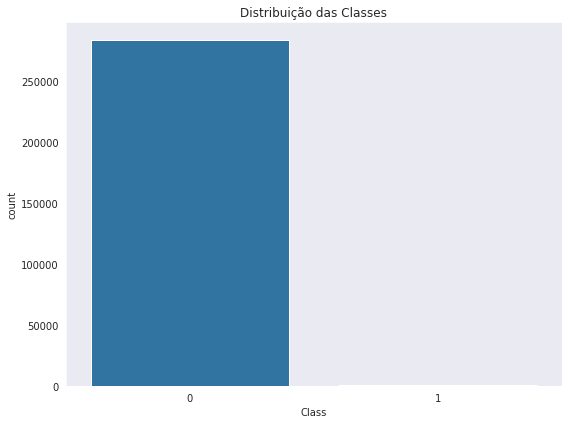

In [5]:
# Imprimir distribuição de classes e plotar um gráfico para visualização
print(df.Class.value_counts())
print("\nFraudes representam {:.2f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')

fig.tight_layout();

Seguindo nossa análise, agora vamos verificar se identificamos diferenças entre as transações de acordo com o tempo. Para isso iremos transformar a coluna `Time` de segundos para horas.

In [6]:
df.Time.describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [7]:
df_copy = df.copy()
df_copy.loc[:,'Time'] = df_copy.Time/3600
df_copy['Time'].tail(5)

284802    47.996111
284803    47.996389
284804    47.996667
284805    47.996667
284806    47.997778
Name: Time, dtype: float64

Com a coluna `Time` transformada em horas, agora vamos plotar dois gráficos para compararmos as distribuições das transações de acordo com o horário efetuado.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Transações normais')

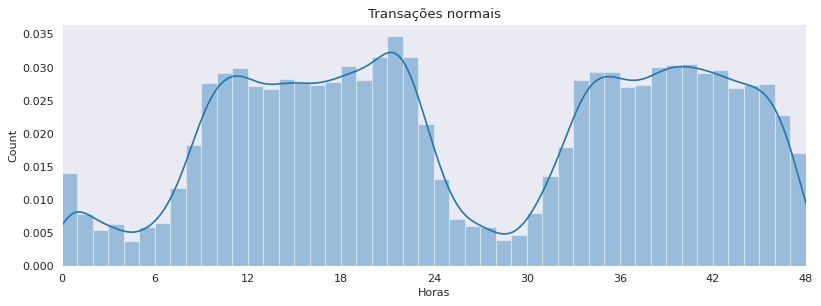

In [8]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(df_copy.Time[df_copy.Class == 0], bins=48)
plt.xlim([0,48])
plt.xticks(np.arange(0,54,6))
plt.xlabel('Horas')
plt.ylabel('Count')
plt.title('Transações normais')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Transações Fraudulentas')

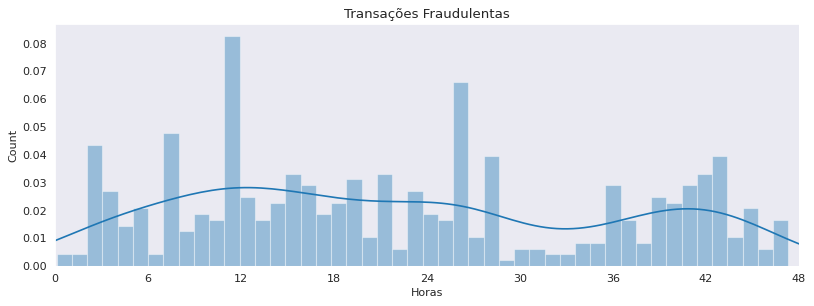

In [9]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(df_copy.Time[df_copy.Class == 1], bins=48)
plt.xlim([0,48])
plt.xticks(np.arange(0,54,6))
plt.xlabel('Horas')
plt.ylabel('Count')
plt.title('Transações Fraudulentas')

Podemos observar que as transações não-fraudulentas são menores entre 00h-06h, o que é normal visto que a maioria da população estão dormindo nesse intervalo de horas. 

Já as transações fraudelentas são maiores nesses horários.

Outra análise importante a ser feita, é identificar as diferenças entre os valores usados nas transações. Para isso vamos plotar um boxplot.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


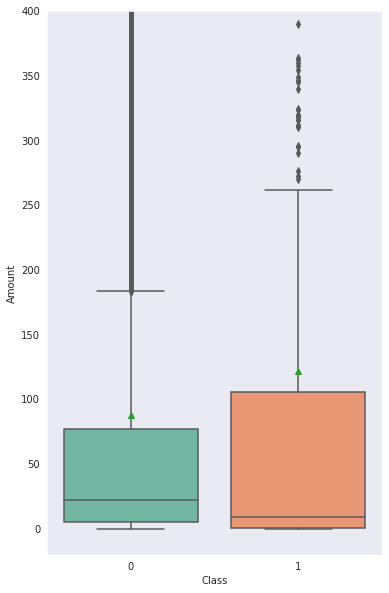

In [10]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True,palette='Set2', ax=ax)
plt.ylim((-20, 400))

plt.show();

In [11]:
print("Média de valores em transações Normais: {}".format(df[df.Class == 0].Amount.mean()))
print("Média de valores em transações Fraudulentas: {}".format(df[df.Class == 1].Amount.mean()))

Média de valores em transações Normais: 88.29102242225574
Média de valores em transações Fraudulentas: 122.21132113821133


Identificamos que a média dos valores em transações fraudulentas são maiores do que as normais. 

## Preparação dos Dados

**Balanceamento dos dados**

Iniciando a preparação dos dados para trabalharmos nosso modelo de Machine Learning, vamos plotar um gráfico de correlação para analisar o impacto do desbalanceamento dos dados. 

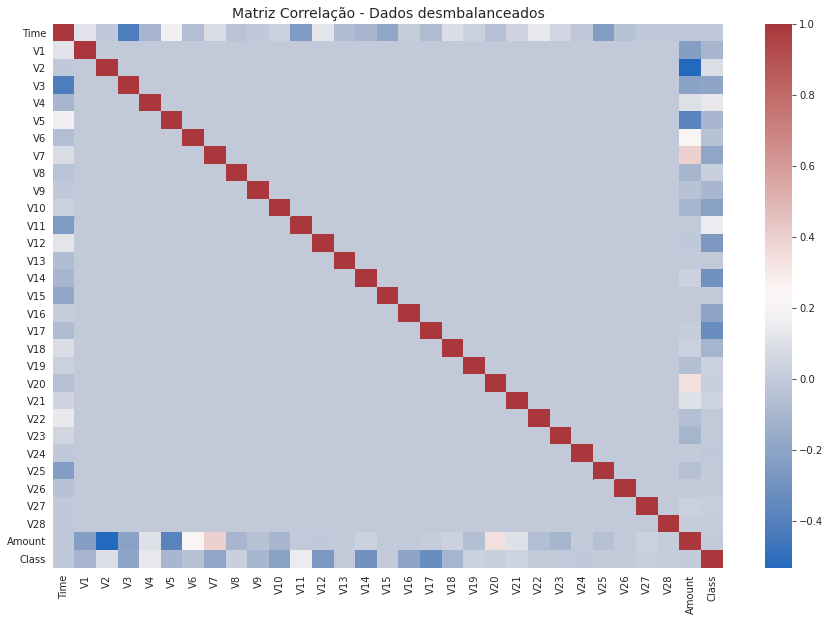

In [12]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(15,10))         

# Imbalanced DataFrame Correlation
corr = df.corr()
sns.heatmap(corr, cmap='vlag', annot_kws={'size':30}, ax=ax)
ax.set_title("Matriz Correlação - Dados desmbalanceados", fontsize=14)
plt.show()

Como é visto no gráfico acima, não há correlação entre os dados. Para resolvermos esse problema, vamos balancear os dados de uma maneira igualitária usando o método `sample` para embaralhar os dados e dividir em quantidades iguais.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


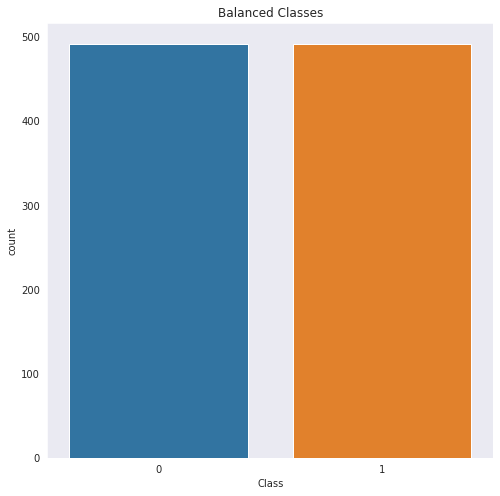

In [13]:
# Embaralhar dataset
shuffled_df = df.sample(frac=1,random_state=4)

# Separar coluna fraude
fraud_df = df.loc[shuffled_df['Class'] == 1]

# Selecionar aletoriamente 492 dados de casos de não-fraudes
normal_df = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=492,random_state=42)

# Concatenar classes novamente
normalized_df = pd.concat([fraud_df, normal_df])

# Plotar gráfico de barras após balanceamento
plt.figure(figsize=(8, 8))
sns.countplot('Class', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

Agora as classes possuem a mesma quantidade de dados. Para visualizarmos o impacto positivo que ganhamos com esse balanceamento, vamos plotar novamente o gráfico de correlação com esse novo dataset. 

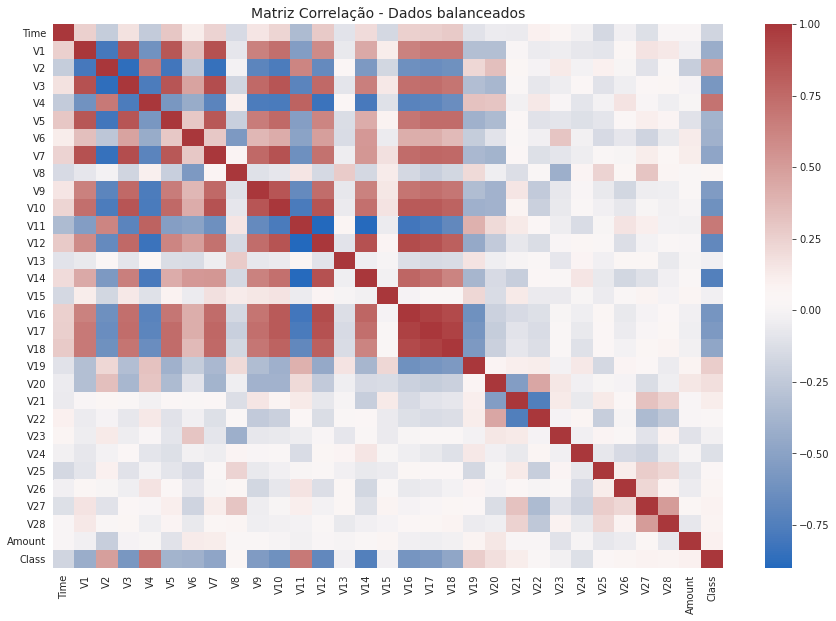

In [14]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(15,10))         

# Imbalanced DataFrame Correlation
corr = normalized_df.corr()
sns.heatmap(corr, cmap='vlag', annot_kws={'size':30}, ax=ax)
ax.set_title("Matriz Correlação - Dados balanceados", fontsize=14)
plt.show()

**Padronização dos dados**

Para esta etapa, uma vez que a coluna `Amount` possui *outliers* será usada a padronização por meio da classe `StandardScaler`.

In [15]:
normalized_df.drop(labels=['Class', 'Time'], axis=1)
normalized_df['Amount'] = StandardScaler().fit_transform(normalized_df['Amount'].values.reshape(-1, 1))
normalized_df['Time'] = StandardScaler().fit_transform(normalized_df['Time'].values.reshape(-1, 1))

normalized_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,-1.868595,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.472565,1
623,-1.867201,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.989304,1
4920,-1.782964,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.644025,1
6108,-1.729677,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.197990,1
6329,-1.718424,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.467911,1


**Dividr conjunto entre dados de treino e teste**

In [16]:
# separar variáveis entre X e y
X = normalized_df.drop('Class', axis=1)
y = normalized_df['Class']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

**Emsemble**

Quando falamos de Machine Learning, existem diversos tipos de modelos diferente para trabalharmos e cada um com sua particularidade. Alguns exemplos são Regressão Linear, Random Forest, Linear SVC, entre outros. 

Usando Emsemble podemos podemos combinar diferentes modelos e fazer uma média de previsões para predizer qual modelo terá o melhor resultado final. 

In [22]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = LinearSVC()
voting_clf = VotingClassifier( estimators=[('lr', log_clf), ('rf', rnd_clf),
 ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

model = []
accuracy = []
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
  clf.fit(X_train, y_train)
  y_proba = clf.predict(X_test)
  model.append(clf.__class__.__name__)
  accuracy.append(accuracy_score(y_test,y_proba))

col = ['Acurácia']
ac = pd.DataFrame(data=accuracy, index = model,columns=col)
ac

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Acurácia
LogisticRegression,0.934959
RandomForestClassifier,0.930894
LinearSVC,0.934959
VotingClassifier,0.939024


O modelo VotingClassfier que foi criado com a junção de outros modelos, obteve uma maior Acurácia.

## Criação do modelo de Machine Learning

Com a definição do melhor modelo vamos criar nosso classificador e realizar previsões sobre nossos dados de teste. 

In [18]:
model = VotingClassifier( estimators=[('lr', log_clf), ('rf', rnd_clf),
 ('svc', svm_clf)], voting='hard')
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [19]:
y_pred = model.predict(X_test)

Com o modelo criado e as previsões feitas, podemos avaliar o desempenho. Vamos plotar uma matriz de confusão para ver a taxa de acertos entre as transações.

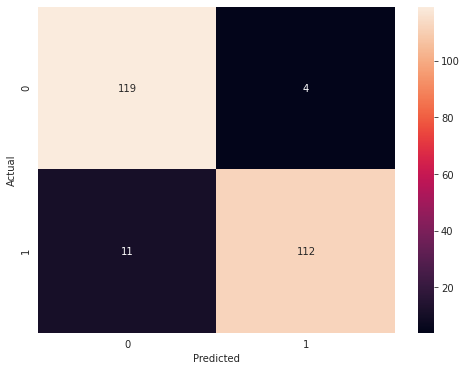

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d'
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9154    0.9675    0.9407       123
           1     0.9655    0.9106    0.9372       123

    accuracy                         0.9390       246
   macro avg     0.9405    0.9390    0.9390       246
weighted avg     0.9405    0.9390    0.9390       246



Tivemos uma precisão de acerto em 96% para casos de fraudes e 91% para não fraudes. E uma Acurácia de 94%.

## Conclusão

Através dessa análise podemos observar algumas diferenças entre as transações fraudelentas e não, como o valores e o horário de compra.

Apesar do modelos não possuir valores ausentes, tivemos um trabalho para realizar o balanceamento dos dados.

Nosso modelo apesar de um bom resultado final ainda há margem para melhora, visto que ainda ocorrem os casos de falsos positivos. Podemos realizar testes com outros modelos e também otimizar seus parâmetros.

